## clustering the colors of an image with KMeans algorithm

In [1]:
import cv2 as cv
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import pandas as pd
from tqdm.notebook import tqdm
import pickle 
from collections import OrderedDict
from numba import jit

**Read and show the image**

In [2]:
img = cv.imread('fruits-dreamstime.png')
img_RGB = cv.cvtColor(img,  cv.COLOR_BGR2RGB)

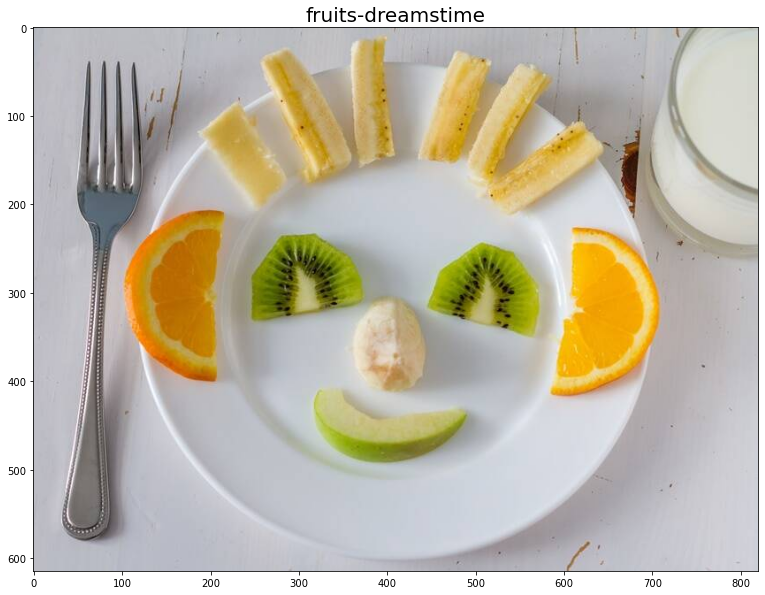

In [3]:
plt.figure(figsize=(15,10))
plt.imshow(img_RGB)
plt.title("fruits-dreamstime", size=20);

**Convert the `BGR` channel to `HSV`**

In [4]:
img_HSV = cv.cvtColor(img,  cv.COLOR_BGR2HSV)
img_HSV.shape

(615, 820, 3)

In [5]:
img_hue = img_HSV[:, :, 0]
img_hue.shape

(615, 820)

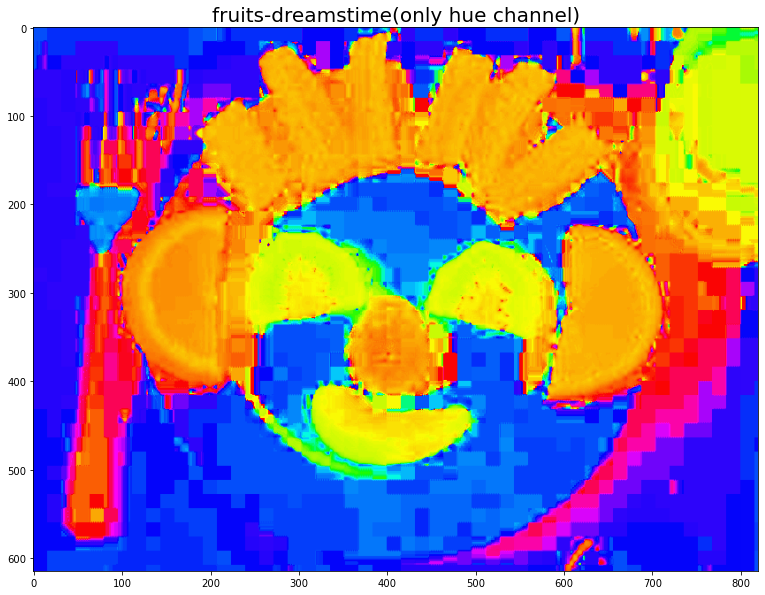

In [6]:
D = (np.zeros((img.shape[0], img.shape[1]))).astype(np.uint8)
plt.figure(figsize=(15,10))
plt.imshow(cv.cvtColor(np.stack([img_HSV[:, :, 0], D+250, D+250], axis=2), cv.COLOR_HSV2RGB))
plt.title("fruits-dreamstime(only hue channel)", size=20);

**preprocessing `normalize` and `feature scaling`**

In [81]:
img_normal = MinMaxScaler(feature_range=(0, 1))
img_normal = img_normal.fit_transform(img_hue.reshape(-1, 1))

**Training the model with `KMeans(n_clusters=9)` estimator**

In [8]:
km = KMeans(n_clusters=9)
km = km.fit(img_normal)
predictions = km.predict(img_normal)

**Create a empty numpy ndarray for transforming prediction group number to the colores code.**

In [9]:
img_km = np.empty(img_RGB.shape)

In [10]:
colors = list(OrderedDict({
    'red': (1, 0, 0),
    'white': (1, 1, 1),
    'blue': (0, 0, 1),
    'green': (0, 1, 0),
    'yellow':(1, 1 , 0),
    'Cyan ':(0, 1 , 1),
    'magenta':(1, 0, 1),
    'back': (0, 0, 0),
    'deep pink':(1,20/255,147/255)
    }).items())


def set_color():
    '''
    assigns to each predictions a color code.
    '''
    for pixel in range(504300):
        color_prediction = predictions[pixel]

        row = pixel//820
        col = pixel-((row) * 820)

        img_km[row, col, :] = colors[color_prediction][1]

set_color()

**Compare `Original` image with the `Clustered image`**

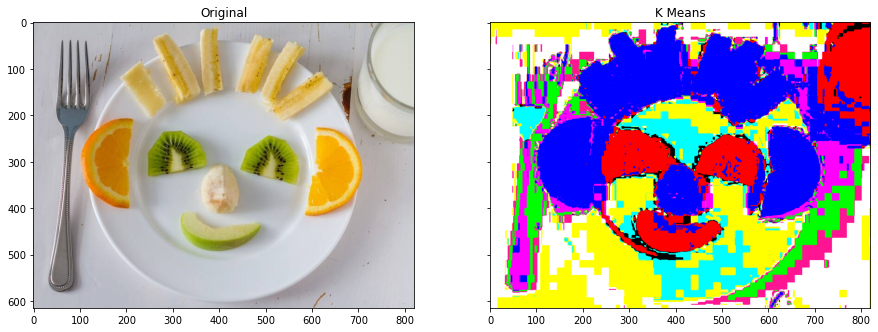

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))
ax1.set_title("Original")
ax1.imshow(img_RGB)
ax2.set_title('K Means')
ax2.imshow(img_km);

**Visualisation check for several `n-Clusters`**

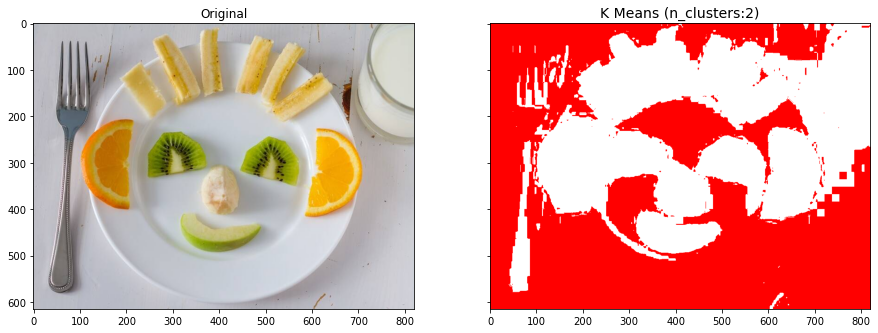

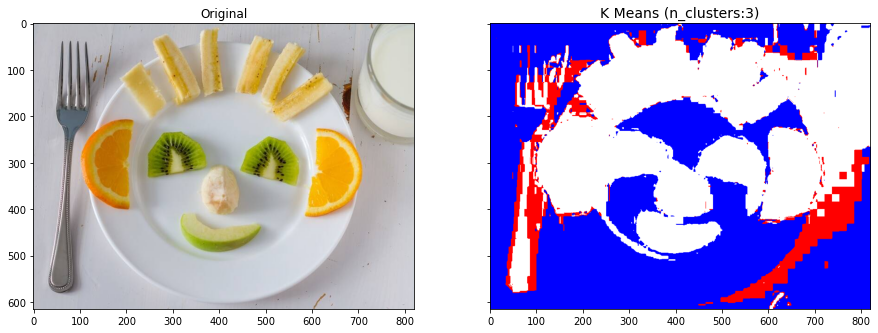

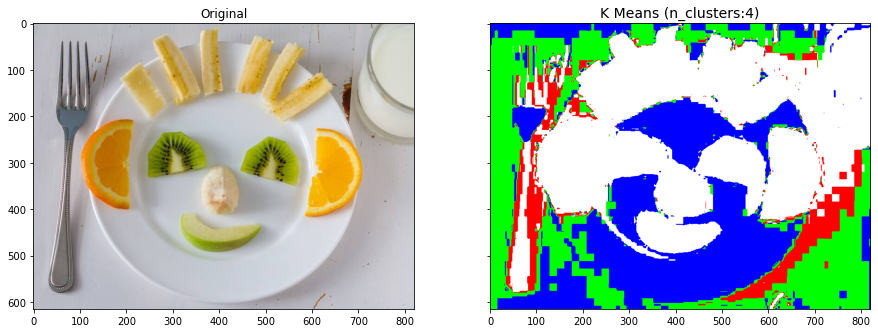

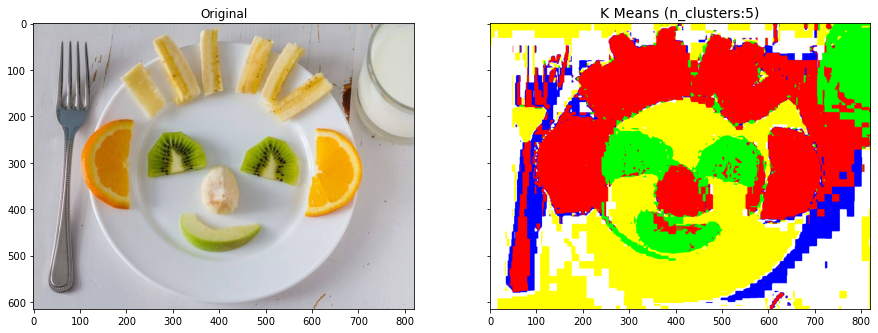

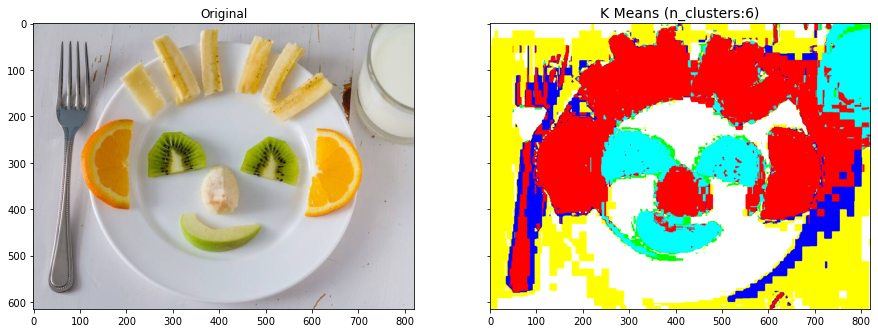

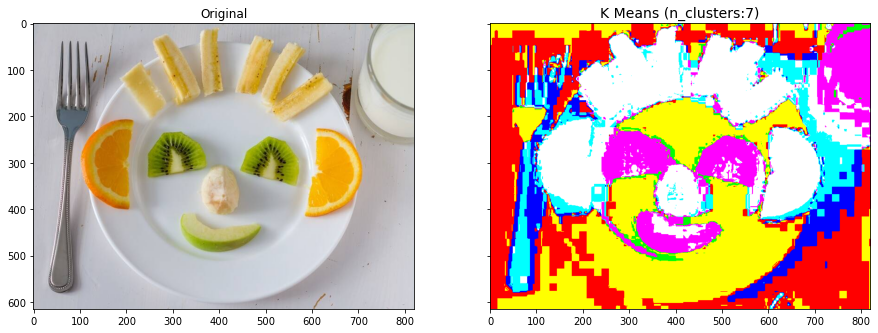

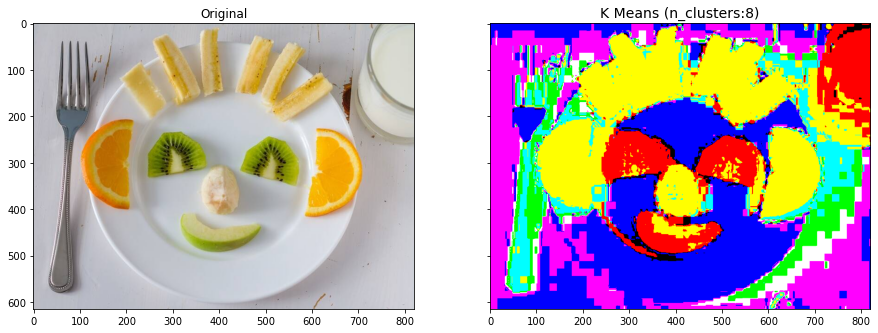

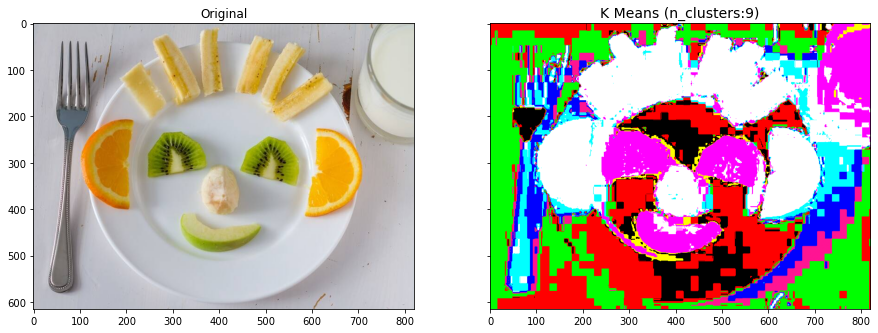

In [12]:


for n in range(2, 10):

    km = KMeans(n_clusters=n)
    km = km.fit(img_normal)
    predictions = km.predict(img_normal)
    
    set_color()

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))
    ax1.set_title("Original")
    ax1.imshow(img_RGB)
    ax2.set_title(f'K Means (n_clusters:{n})', size=14)
    ax2.imshow(img_km)
    plt.pause(0.01);

**Finde the best value `n_clusters` hyperparameter**

  0%|          | 0/14 [00:00<?, ?it/s]

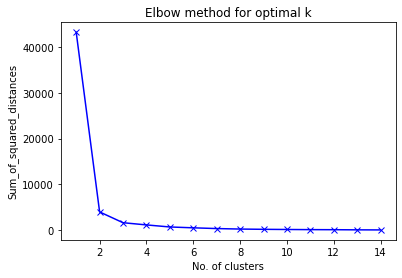

In [43]:
from sklearn.cluster import KMeans

ks = range(1, 15)
sum_of_squared_distances = []
for k in tqdm(ks):
    km = KMeans(n_clusters=k)
    km = km.fit(img_normal)
    sum_of_squared_distances.append(km.inertia_)
plt.plot(ks, sum_of_squared_distances, 'bx-')
plt.title('Elbow method for optimal k')
plt.xlabel('No. of clusters')
plt.ylabel('Sum_of_squared_distances')
plt.show()

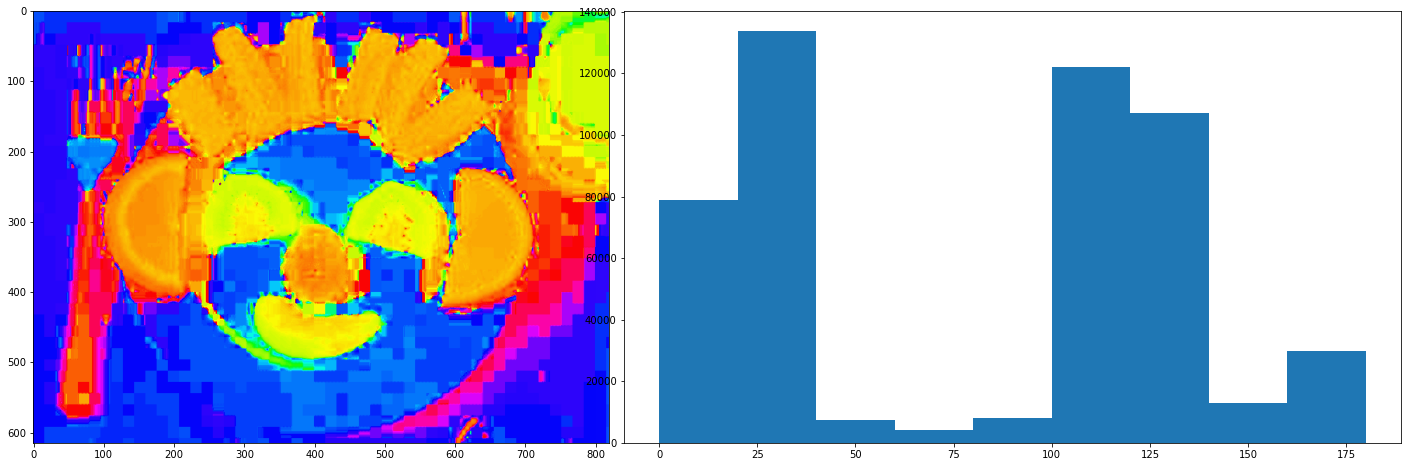

In [115]:
fig = plt.figure(figsize=(12,3))
ax1 = fig.add_axes([0.1,5,0.9,2])
ax2 = fig.add_axes([0.9,5,0.9,2])
ax1.imshow(cv.cvtColor(np.stack([img_HSV[:, :, 0], D+250, D+250], axis=2), cv.COLOR_HSV2RGB))
ax2.hist(np.ravel(img_hue), bins=np.arange(0,200, 20));

**Save `trained model` and all other important files.**

In [122]:
dict_files = {
    'sum_of_squared_distances':sum_of_squared_distances,
    'image_KMeans': img_km,
    'trianed_model': km
        }

with open('files_fruits.pkl', 'wb') as pkl_file:
    pickle.dump(dict_files, pkl_file)

## Painting according the Original image center.

In [94]:
km = KMeans(n_clusters=60)
km = km.fit(img_normal)
predictions = km.predict(img_normal)

In [95]:
centers_hue = MinMaxScaler(feature_range=(0, 255))
centers_hue = centers_hue.fit_transform(km.cluster_centers_)

In [96]:
colors_code = []
for i in range(len(centers_hue)):
    colors_code.append(list((img_HSV[abs(img_hue-centers_hue[i])==(abs(img_hue-centers_hue[i])).min()] ).mean(axis=0).astype(np.uint8)))

In [97]:
def set_color():
    '''
    assigns to each predictions a color code.
    '''
    for pixel in tqdm(range(504300)):
        color_prediction = predictions[pixel]

        row = pixel//820
        col = pixel-((row) * 820)

        img_km[row, col, :] = colors_code[color_prediction]

set_color()

  0%|          | 0/504300 [00:00<?, ?it/s]

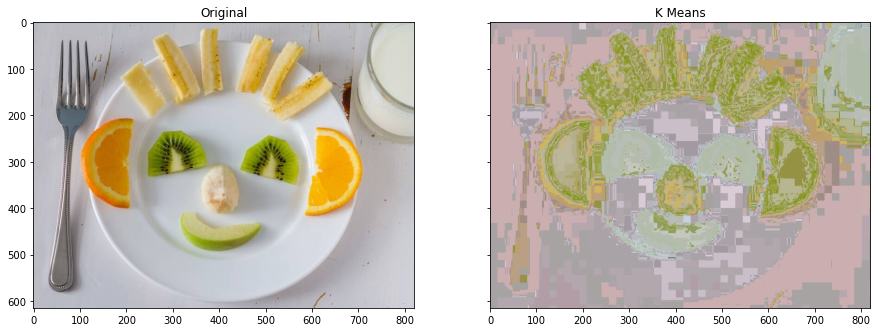

In [98]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))
ax1.set_title("Original")
ax1.imshow(img_RGB)
ax2.set_title('K Means')
ax2.imshow(cv.cvtColor(img_km.astype(np.uint8),  cv.COLOR_HSV2RGB));